In [237]:
from zipfile import ZipFile
from urllib.request import urlopen   
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium.plugins import MarkerCluster, HeatMap
import json


from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, 
                                     cross_val_score, GridSearchCV, 
                                     learning_curve, validation_curve) 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import (XGBClassifier, plot_importance)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline 
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE


import pickle

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='darkgrid')
c = '#386B7F'

import pylab as plot
params = {'legend.fontsize': 12, 'axes.labelsize': 20, 'axes.titlesize': 20,'figure.figsize': [15, 10], 'legend.fontsize': 'medium', 'xtick.labelsize':'large', 'ytick.labelsize':'large'}
plot.rcParams.update(params)
sns.set(style='darkgrid')

pd.__version__

'0.23.0'

# Task:

1. Download the “2014 Road Safety - Accidents 2014” data from: https://data.gov.uk/dataset/road-accidents-safety-data
2. Build a model that predicts if a police officer is likely to attend an accident or not.
3. Summarise my findings. Things to consider including in the report are:
    * Approach taken (e.g. algorithms and tools)
    
    * Main challenges
    
    * Insight I gained from working with the data
    
    * How useful is the model
    
    * Ideas if I had more time/resource?
    

# Summary:

* Most of the accidents are not life-threatening

* Accidents occur mainly when the conditions are good: dry road, daylight

* The speed limits in which most fatal accidents occured are 30 and 60 mph

* There are situations in which an officer did not attend the accident scene, however, everytime that there were fatalities an officer attended the scene

* People seem to be less careful during good conditions.

* Most of the accidents are caused by up to 3 vehicles

* Most accidents occur where the speed limit is 30mph

* The estimator used is good at recognizing the classes 1, but not so good for 0.


# 1) Download data

In [2]:
url="http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Accidents_2014.zip"

url = urlopen(url)
output = open('zipFile.zip', 'wb')          
output.write(url.read())
output.close()

df = pd.read_csv('zipFile.zip', na_values = -1)         

os.remove('zipFile.zip')   # remove the copy of the zipfile on disk

In [3]:
url = urlopen("http://data.dft.gov.uk/road-accidents-safety-data/Road-Accident-Safety-Data-Guide.xls")
xls = pd.ExcelFile(url) # read the entire excel file


# 2) Data exploration

Check the dataframe

In [4]:
df.head(3)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,201401BS70001,524600,179020,-0.206443,51.496345,1,3,2,1,09/01/2014,...,0,0,1,2,2.0,0.0,0.0,1,2,E01002814
1,201401BS70002,525780,178290,-0.189713,51.489523,1,3,2,1,20/01/2014,...,0,5,7,1,1.0,0.0,0.0,1,2,E01002894
2,201401BS70003,526880,178430,-0.173827,51.490536,1,3,2,1,21/01/2014,...,0,0,1,1,1.0,0.0,0.0,1,1,E01002822


In [5]:
df.tail(3)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
146319,2014984137714,321337,566365,-3.230826,54.985668,98,3,1,1,09/12/2014,...,0,0,4,1,4.0,0.0,0.0,2,1,NaN
146320,2014984138414,323869,566853,-3.191397,54.990446,98,2,3,2,17/12/2014,...,0,0,6,2,2.0,0.0,0.0,2,1,NaN
146321,2014984139614,314072,579971,-3.348426,55.106700,98,3,2,2,24/12/2014,...,0,0,1,1,2.0,0.0,0.0,2,1,NaN


In [6]:
df.dtypes

Accident_Index                                  object
Location_Easting_OSGR                            int64
Location_Northing_OSGR                           int64
Longitude                                      float64
Latitude                                       float64
Police_Force                                     int64
Accident_Severity                                int64
Number_of_Vehicles                               int64
Number_of_Casualties                             int64
Date                                            object
Day_of_Week                                      int64
Time                                            object
Local_Authority_(District)                       int64
Local_Authority_(Highway)                       object
1st_Road_Class                                   int64
1st_Road_Number                                  int64
Road_Type                                        int64
Speed_limit                                      int64
Junction_D

Let's make sure pandas know our column **Date** is date

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146322 entries, 0 to 146321
Data columns (total 32 columns):
Accident_Index                                 146322 non-null object
Location_Easting_OSGR                          146322 non-null int64
Location_Northing_OSGR                         146322 non-null int64
Longitude                                      146322 non-null float64
Latitude                                       146322 non-null float64
Police_Force                                   146322 non-null int64
Accident_Severity                              146322 non-null int64
Number_of_Vehicles                             146322 non-null int64
Number_of_Casualties                           146322 non-null int64
Date                                           146322 non-null datetime64[ns]
Day_of_Week                                    146322 non-null int64
Time                                           146322 non-null object
Local_Authority_(District)                    

**LSOA_of_Accident_Location** has plenty of cells that have no value. I will drop the whole column.

In addition, **Junction_Control**, **2nd_Road_Class**, **2nd_Road_Number** will also be dropped as it would be very difficult to impute these values.

There's only one NaN for **Special_Conditions_at_Site** and **Carriageway_Hazards**. I will drop the rows in which these values are NaN

In [9]:
df.drop(['LSOA_of_Accident_Location', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number'], axis=1, inplace=True)

In [10]:
df.dropna(subset=['Special_Conditions_at_Site', 'Carriageway_Hazards'], how='any', inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146321 entries, 0 to 146321
Data columns (total 28 columns):
Accident_Index                                 146321 non-null object
Location_Easting_OSGR                          146321 non-null int64
Location_Northing_OSGR                         146321 non-null int64
Longitude                                      146321 non-null float64
Latitude                                       146321 non-null float64
Police_Force                                   146321 non-null int64
Accident_Severity                              146321 non-null int64
Number_of_Vehicles                             146321 non-null int64
Number_of_Casualties                           146321 non-null int64
Date                                           146321 non-null datetime64[ns]
Day_of_Week                                    146321 non-null int64
Time                                           146321 non-null object
Local_Authority_(District)                    

Now we can try to use **Weather_Conditions** to impute values for **Road_Surface_Conditions**

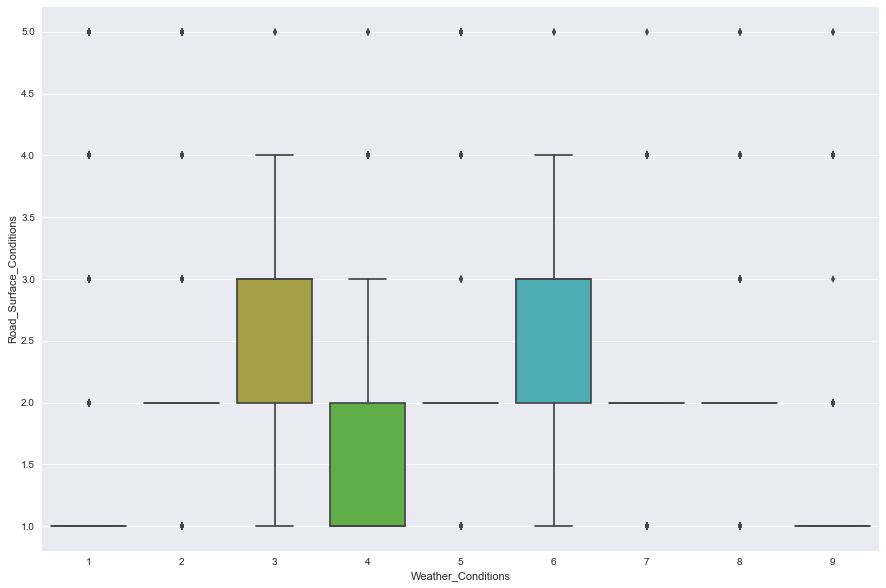

In [12]:
sns.boxplot(x = 'Weather_Conditions', y = 'Road_Surface_Conditions',  data = df)

In [13]:
grouped_df = df[['Road_Surface_Conditions', 'Weather_Conditions']].groupby('Weather_Conditions').median()

In [14]:
grouped_df=grouped_df.reset_index()
grouped_df

,Weather_Conditions,Road_Surface_Conditions
0,1,1.0
1,2,2.0
2,3,3.0
3,4,1.0
4,5,2.0
5,6,3.0
6,7,2.0
7,8,2.0
8,9,1.0


This dataframe will help us impute missing **Road_Surface_Conditions** values based on the grouped **Weather_Conditions** and median value of the **Road_Surface_Conditions**.

In [15]:
def status(feature):

    print ('Processing',feature,': ok')

In [16]:
# Feature Engineering
def fill_road_conditions(row):
    condition = (
        (grouped_df['Weather_Conditions'] == row['Weather_Conditions'])) 
    return grouped_df[condition]['Road_Surface_Conditions'].values[0]


def process_road_conditions():    
    """A function that fills the missing values of the Road_Surface_Conditions variable"""
    global df
     
    df['Road_Surface_Conditions'] = df.apply(lambda row: fill_road_conditions(row) if np.isnan(row['Road_Surface_Conditions']) \
                                             else row['Road_Surface_Conditions'], axis=1)
    status('Road_Surface_Conditions')
    return df

In [17]:
df = process_road_conditions()

Processing Road_Surface_Conditions : ok


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146321 entries, 0 to 146321
Data columns (total 28 columns):
Accident_Index                                 146321 non-null object
Location_Easting_OSGR                          146321 non-null int64
Location_Northing_OSGR                         146321 non-null int64
Longitude                                      146321 non-null float64
Latitude                                       146321 non-null float64
Police_Force                                   146321 non-null int64
Accident_Severity                              146321 non-null int64
Number_of_Vehicles                             146321 non-null int64
Number_of_Casualties                           146321 non-null int64
Date                                           146321 non-null datetime64[ns]
Day_of_Week                                    146321 non-null int64
Time                                           146321 non-null object
Local_Authority_(District)                    

How does our target look like?

In [19]:
df.Did_Police_Officer_Attend_Scene_of_Accident.unique()

array([2, 1])

We need to understand the codes:

In [20]:
# list all the sheets:
xls.sheet_names

['Introduction',
 'Export Variables',
 'Police Force',
 'Accident Severity',
 'Day of Week',
 'Local Authority (District)',
 'Local Authority (Highway)',
 '1st Road Class',
 'Road Type',
 'Junction Detail',
 'Junction Control',
 '2nd Road Class',
 'Ped Cross - Human',
 'Ped Cross - Physical',
 'Light Conditions',
 'Weather',
 'Road Surface',
 'Special Conditions at Site',
 'Carriageway Hazards',
 'Urban Rural',
 'Police Officer Attend',
 'Vehicle Type',
 'Towing and Articulation',
 'Vehicle Manoeuvre',
 'Vehicle Location',
 'Junction Location',
 'Skidding and Overturning',
 'Hit Object in Carriageway',
 'Veh Leaving Carriageway',
 'Hit Object Off Carriageway',
 '1st Point of Impact',
 'Was Vehicle Left Hand Drive',
 'Journey Purpose',
 'Sex of Driver',
 'Age Band',
 'Vehicle Propulsion Code',
 'Casualty Class',
 'Sex of Casualty',
 'Age of Casualty',
 'Casualty Severity',
 'Ped Location',
 'Ped Movement',
 'Car Passenger',
 'Bus Passenger',
 'Ped Road Maintenance Worker',
 'Casualty Ty

In [21]:
data_dict_police_attended = pd.read_excel(xls, sheetname="Police Officer Attend")

In [22]:
data_dict_police_attended

,code,label
0,1,Yes
1,2,No
2,3,No - accident was reported using a self comple...


We can see that for our target we only have codes 1 and 2

In [23]:
df.Accident_Index.nunique()

146321

In [24]:
len(df)

146321

The indexes are unique values. They could be understood as name given to each accident

I will replace 2 with 0 in **Did_Police_Officer_Attend_Scene_of_Accident**

In [25]:
df['Did_Police_Officer_Attend_Scene_of_Accident'].replace(2, 0, inplace=True)

In [26]:
df.Did_Police_Officer_Attend_Scene_of_Accident.unique()

array([0, 1])

In [27]:
df["Did_Police_Officer_Attend_Scene_of_Accident"].value_counts()

1    119607
0     26714
Name: Did_Police_Officer_Attend_Scene_of_Accident, dtype: int64

Classes are not balanced

Let's make sure **Time** column is time and let's get the Hour

In [28]:
df['Hour'] = pd.to_datetime(df["Time"], format='%H:%M').dt.hour
df.drop(['Time'], axis=1, inplace=True)

Let's also create a **Month** column:

In [29]:
df['Month'] = df.Date.dt.month

In [30]:
#df.dtypes

We need to make sure the categorical variables are *object* type. 

In [31]:
def convert_to_object(cols):
    global df
    for c in cols:
        df[c] = df[c].astype(str)
        status(c)
    return df

In [32]:
df=convert_to_object(['Police_Force', 'Accident_Severity', 'Day_of_Week', '1st_Road_Class', 'Road_Type', 'Junction_Detail',\
                     'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',\
                     'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards',\
                     'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Month', \
                      'Local_Authority_(Highway)', 'Local_Authority_(District)'])

Processing Police_Force : ok
Processing Accident_Severity : ok
Processing Day_of_Week : ok
Processing 1st_Road_Class : ok
Processing Road_Type : ok
Processing Junction_Detail : ok
Processing Pedestrian_Crossing-Human_Control : ok
Processing Pedestrian_Crossing-Physical_Facilities : ok
Processing Light_Conditions : ok
Processing Weather_Conditions : ok
Processing Road_Surface_Conditions : ok
Processing Special_Conditions_at_Site : ok
Processing Carriageway_Hazards : ok
Processing Urban_or_Rural_Area : ok
Processing Did_Police_Officer_Attend_Scene_of_Accident : ok
Processing Month : ok
Processing Local_Authority_(Highway) : ok
Processing Local_Authority_(District) : ok


Local Authority (Highway) will be label encoded using sklearn:

In [33]:
lb_make = LabelEncoder()
df["LA_Highway"] = lb_make.fit_transform(df["Local_Authority_(Highway)"])
df[["LA_Highway", "Local_Authority_(Highway)"]].head(3)


,LA_Highway,Local_Authority_(Highway)
0,111,E09000020
1,111,E09000020
2,111,E09000020


It's posiible that Local_Authority_(Highway) and Local_Authority_(District) are "the same". If this is the case, I will delete one of them later on.

In [34]:
df=convert_to_object(["LA_Highway"])

Processing LA_Highway : ok


## 2.1) Visualization

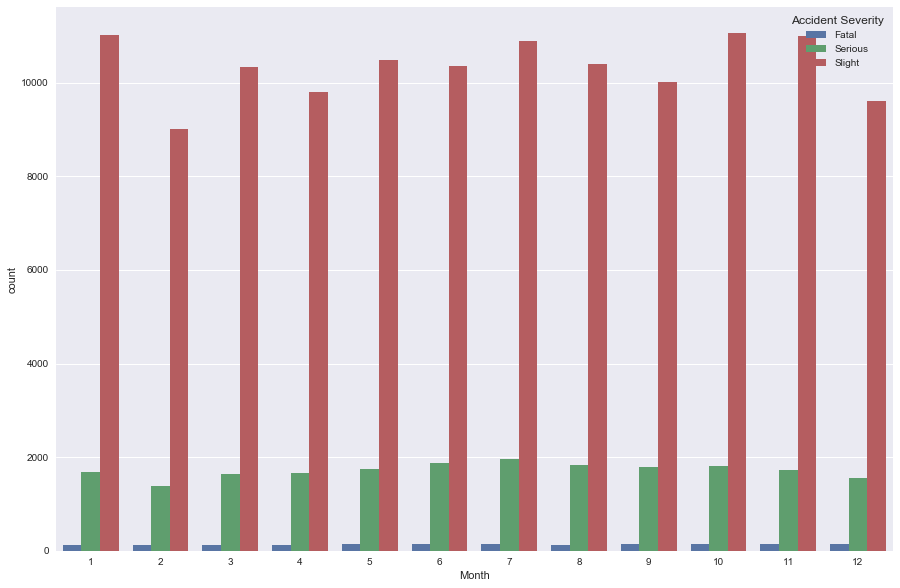

In [35]:
g = sns.countplot(x="Month", data=df, hue = "Accident_Severity", order= ["1", "2","3","4","5","6",'7',"8","9"\
                                                                         ,"10","11","12"]);
g.legend(['Fatal', 'Serious', 'Slight'], title='Accident Severity')

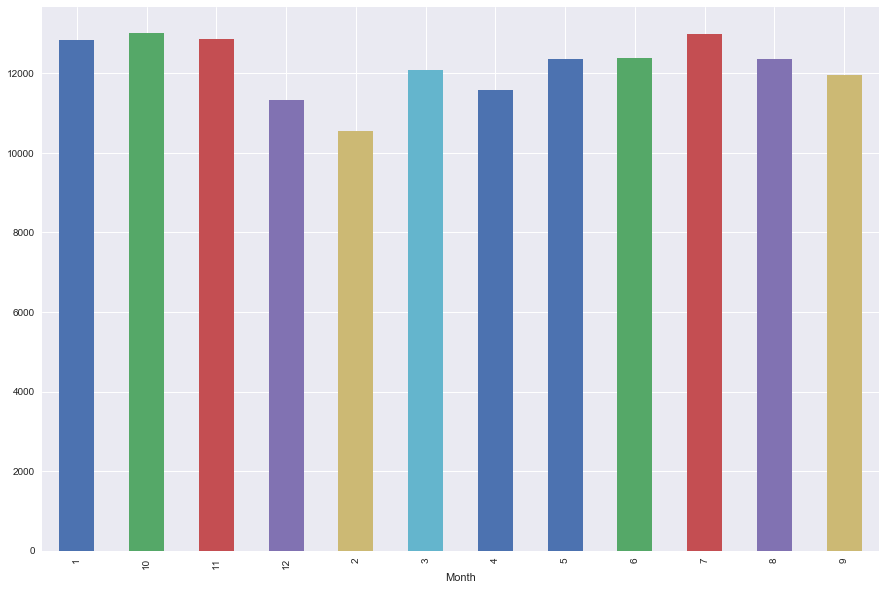

In [36]:
df.groupby(df.Month).Accident_Severity.count().plot(kind = 'bar');

In [37]:
df["Accident_Severity"].value_counts()

3    123987
2     20676
1      1658
Name: Accident_Severity, dtype: int64

We can see that most of the Severity are *slight*.

In [38]:
Fatal = df["Accident_Severity"] == "1"
Serious = df["Accident_Severity"] == "2"
Slight = df["Accident_Severity"] == "3"

fataldf= df[Fatal]
seriousdf=df[Serious]
slightdf=df[Slight]

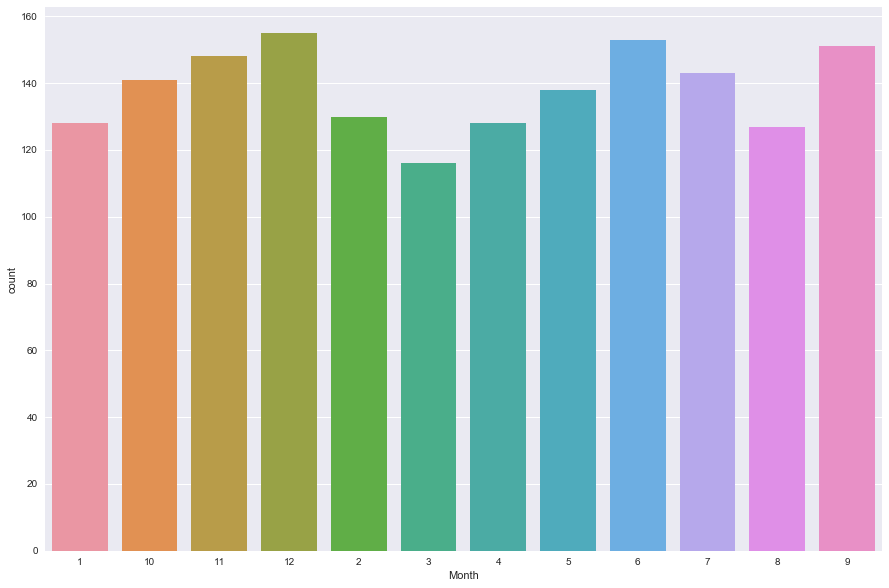

In [39]:
g = sns.countplot(x="Month", data=df[Fatal]);

More fatal accidents from September to December and June + July. March is the month with less fatal accidents.

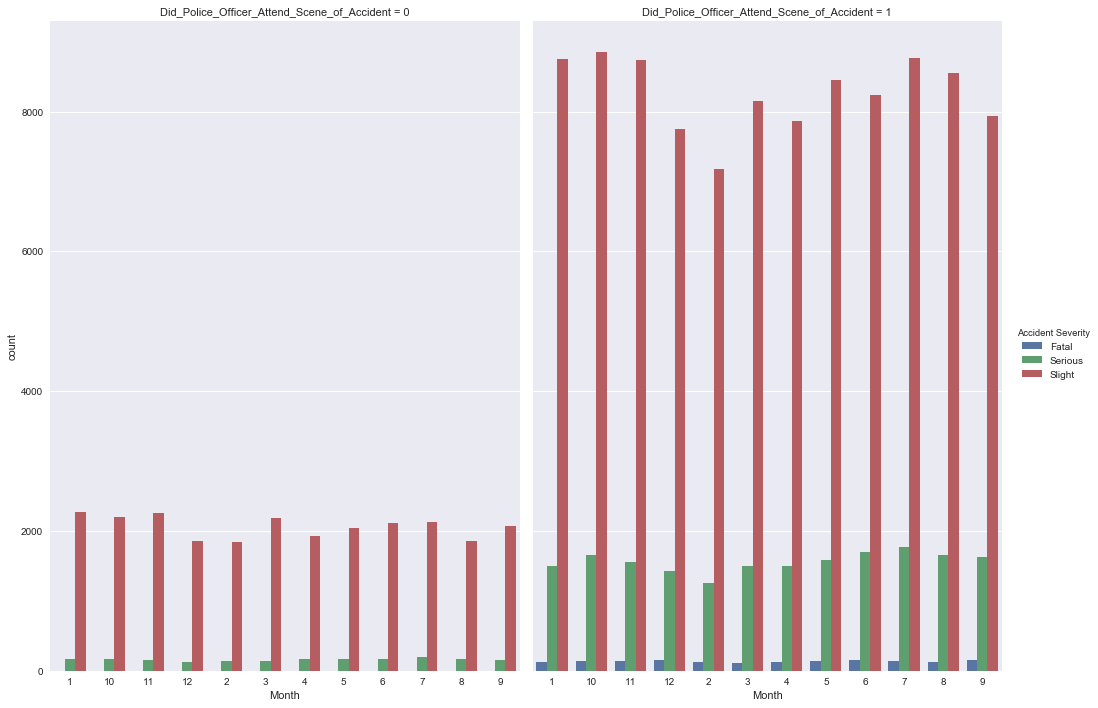

In [40]:
g=sns.factorplot(x="Month", hue="Accident_Severity", col="Did_Police_Officer_Attend_Scene_of_Accident",
                    data=df, kind="count",
                   size=10, aspect=.7);

legend = g._legend

legend.set_title("Accident Severity")
for t, l in zip(legend.texts,('Fatal', 'Serious', 'Slight')):
    t.set_text(l)


Whenever were fatalities, an officer attended the scene. If an officer did not attend the accident location, there was no fatality.

In [41]:
#df.groupby("Local_Authority_(District)")["Accident_Severity"].value_counts().sort_values(ascending=False).head(10)

In [42]:
df["Light_Conditions"].value_counts()

1    108070
4     28449
6      7199
7      1731
5       872
Name: Light_Conditions, dtype: int64

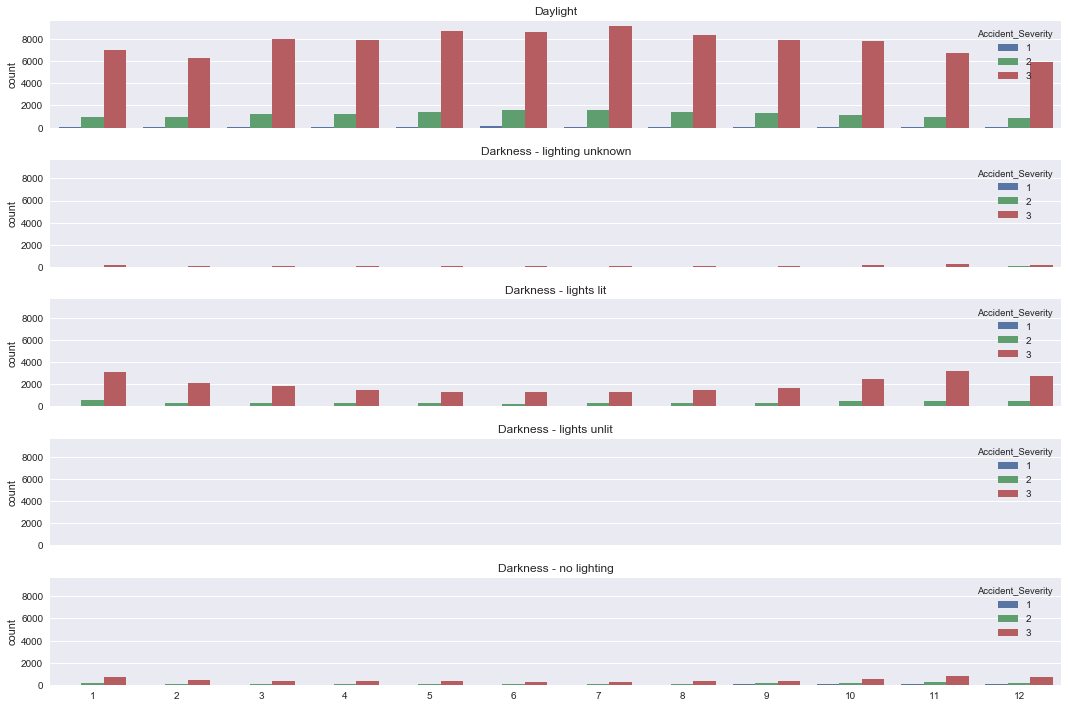

In [43]:
f, axes = plt.subplots(nrows=df['Light_Conditions'].nunique(), ncols=1, sharex = True, sharey = True)
for i,ax_val in zip(df['Light_Conditions'].unique(), range(df['Light_Conditions'].nunique())):
    i = str(i)
    data = df["Light_Conditions"] == i
    sns.countplot(x="Month", data=df[data], hue = "Accident_Severity", order= ["1", "2","3","4","5","6",'7',"8","9"\
                                                                           ,"10","11","12"], ax = axes[ax_val]);
    Title_Dictionary = {
    "1": "Daylight",
    "4": "Darkness - lights lit",
    "5": "Darkness - lights unlit",
    "6": "Darkness - no lighting",
    "7": "Darkness - lighting unknown"
    }

    axes[ax_val].set_title(Title_Dictionary[i])
    axes[ax_val].xaxis.label.set_visible(False)
plt.xlabel("Month")
plt.tight_layout()

We have more accidents when the light conditions are good, during daylight. Fewer accidents occur in darkness - lights unlit.

In [44]:
slightdf["Light_Conditions"].value_counts()

1    92475
4    23899
6     5406
7     1493
5      714
Name: Light_Conditions, dtype: int64

In [45]:
seriousdf["Light_Conditions"].value_counts()

1    14615
4     4188
6     1517
7      221
5      135
Name: Light_Conditions, dtype: int64

In [46]:
fataldf["Light_Conditions"].value_counts()

1    980
4    362
6    276
5     23
7     17
Name: Light_Conditions, dtype: int64

In [47]:
(fataldf['Light_Conditions'] == '1').value_counts()

True     980
False    678
Name: Light_Conditions, dtype: int64

In [48]:
percentage_diff_inc = ((980 - 678)/678)*100
percentage_diff_dec = ((980 - 678)/980)*100

In [49]:
print("Fatal accidents that occur in Daylight is {0:.2f}% bigger than the fatal accidents in other light conditions".\
      format(percentage_diff_inc))
print("Fatal accidents that occur in all light conditions rather than Daylight is {0:.2f}% less than the fatal accidents in Daylight conditions".\
      format(percentage_diff_dec))

Fatal accidents that occur in Daylight is 44.54% bigger than the fatal accidents in other light conditions
Fatal accidents that occur in all light conditions rather than Daylight is 30.82% less than the fatal accidents in Daylight conditions


In [50]:
fataldf["Speed_limit"].value_counts()

30    589
60    586
70    191
40    137
50    127
20     28
Name: Speed_limit, dtype: int64

In [51]:
fataldf.query('Speed_limit == "30"').Speed_limit.count() + fataldf.query('Speed_limit == "60"').Speed_limit.count()

1175

In [52]:
fataldf.query('Speed_limit == "70"').\
Speed_limit.count() + fataldf.query('Speed_limit == "40"').Speed_limit.count()+\
fataldf.query('Speed_limit == "50"').Speed_limit.count() + fataldf.query('Speed_limit == "20"').Speed_limit.count()

483

In [53]:
percentage_diff_inc_spd = ((1175 - 483)/483)*100
percentage_diff_dec_spd = ((1175 - 483)/1175)*100

In [54]:
print("Most Fatal accidents occur when the speed limit is either 30 or 60 mph.\nThe number of fatal accidents in roads of \
30 and 60mph speed limit are {0:.2f}% bigger than the fatal accidents in other speed limits".\
      format(percentage_diff_inc_spd))

Most Fatal accidents occur when the speed limit is either 30 or 60 mph.
The number of fatal accidents in roads of 30 and 60mph speed limit are 143.27% bigger than the fatal accidents in other speed limits


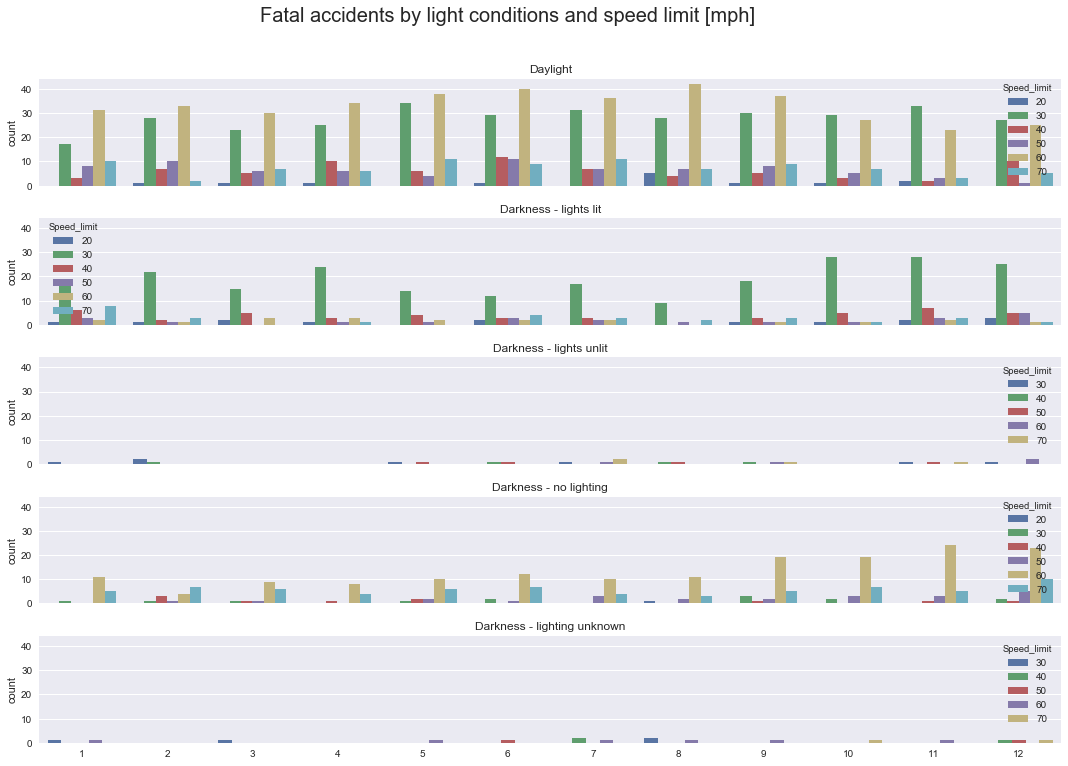

In [55]:
f, axes = plt.subplots(nrows=fataldf['Light_Conditions'].nunique(), ncols=1, sharex = True, sharey = True)
for i,ax_val in zip(fataldf['Light_Conditions'].unique(), range(fataldf['Light_Conditions'].nunique())):
    i = str(i)
    data = fataldf["Light_Conditions"] == i
    sns.countplot(x="Month", data=fataldf[data], hue = "Speed_limit", order= ["1", "2","3","4","5","6",'7',"8","9"\
                                                                           ,"10","11","12"], ax = axes[ax_val]);
    Title_Dictionary = {
    "1": "Daylight",
    "4": "Darkness - lights lit",
    "5": "Darkness - lights unlit",
    "6": "Darkness - no lighting",
    "7": "Darkness - lighting unknown"
    }

    axes[ax_val].set_title(Title_Dictionary[i])
    axes[ax_val].xaxis.label.set_visible(False)
plt.text(5, 300, 'Fatal accidents by light conditions and speed limit [mph]', ha='center', va='center', fontsize=20)
plt.xlabel("Month")
plt.tight_layout()

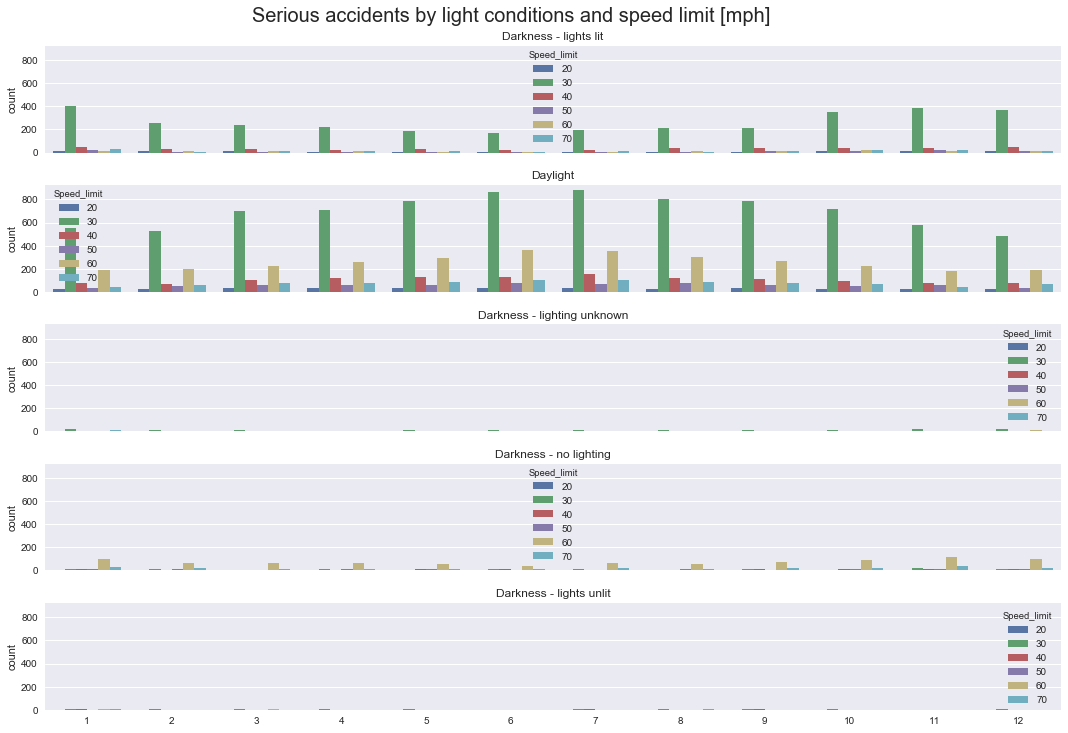

In [56]:
f, axes = plt.subplots(nrows=seriousdf['Light_Conditions'].nunique(), ncols=1, sharex = True, sharey = True)
for i,ax_val in zip(seriousdf['Light_Conditions'].unique(), range(seriousdf['Light_Conditions'].nunique())):
    i = str(i)
    data = seriousdf["Light_Conditions"] == i
    sns.countplot(x="Month", data=seriousdf[data], hue = "Speed_limit", order= ["1", "2","3","4","5","6",'7',"8","9"\
                                                                           ,"10","11","12"], ax = axes[ax_val]);
    Title_Dictionary = {
    "1": "Daylight",
    "4": "Darkness - lights lit",
    "5": "Darkness - lights unlit",
    "6": "Darkness - no lighting",
    "7": "Darkness - lighting unknown"
    }

    axes[ax_val].set_title(Title_Dictionary[i])
    axes[ax_val].xaxis.label.set_visible(False)
plt.text(5, 6000, 'Serious accidents by light conditions and speed limit [mph]', ha='center', va='center', fontsize=20)
plt.xlabel("Month")
plt.tight_layout()

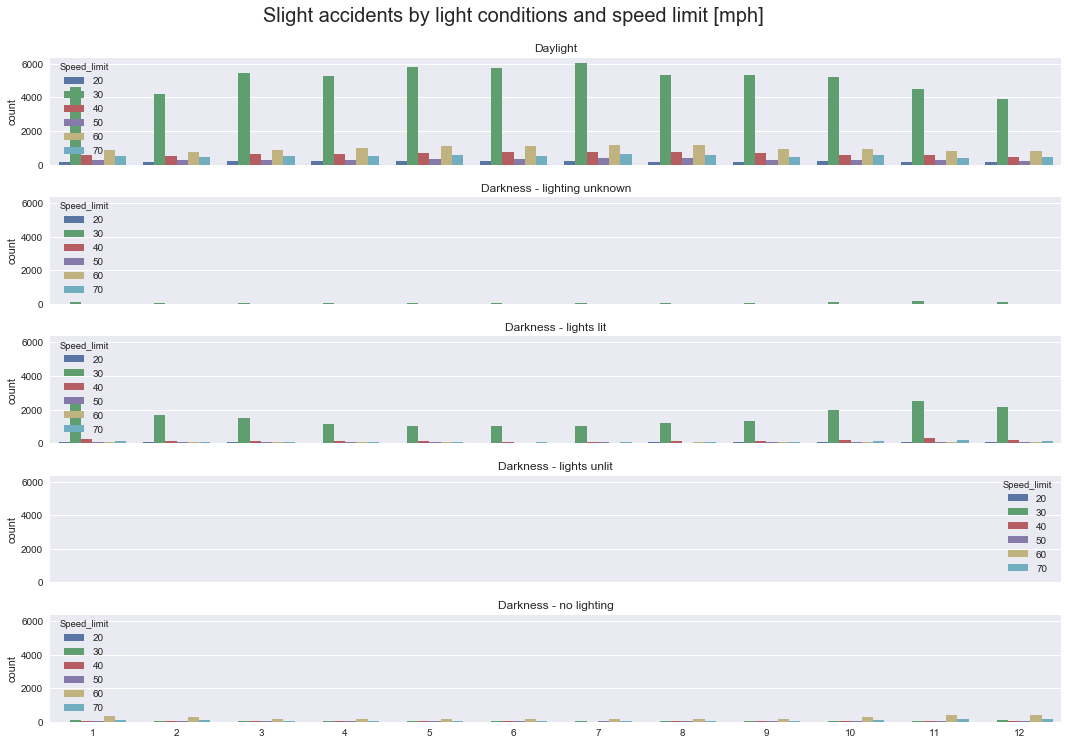

In [57]:
f, axes = plt.subplots(nrows=slightdf['Light_Conditions'].nunique(), ncols=1, sharex = True, sharey = True)
for i,ax_val in zip(slightdf['Light_Conditions'].unique(), range(slightdf['Light_Conditions'].nunique())):
    i = str(i)
    data = slightdf["Light_Conditions"] == i
    sns.countplot(x="Month", data=slightdf[data], hue = "Speed_limit", order= ["1", "2","3","4","5","6",'7',"8","9"\
                                                                           ,"10","11","12"], ax = axes[ax_val]);
    Title_Dictionary = {
    "1": "Daylight",
    "4": "Darkness - lights lit",
    "5": "Darkness - lights unlit",
    "6": "Darkness - no lighting",
    "7": "Darkness - lighting unknown"
    }

    axes[ax_val].set_title(Title_Dictionary[i])
    axes[ax_val].xaxis.label.set_visible(False)
plt.text(5, 42000, 'Slight accidents by light conditions and speed limit [mph]', ha='center', va='center', fontsize=20)
plt.xlabel("Month")
plt.tight_layout()

In [58]:
seriousdf["Speed_limit"].value_counts()

30    11934
60     4124
40     1833
70     1335
50      958
20      492
Name: Speed_limit, dtype: int64

In [59]:
slightdf["Speed_limit"].value_counts()

30    82473
60    15306
40    10047
70     8551
50     4712
20     2898
Name: Speed_limit, dtype: int64

Most fatal accidents occured in dailight and on roads in which the speed limit is 30 or 60 mph.

Most serious accidents occured in dailight and on 30 mph speed limit.

Most slight accidents happened in dailight and where the speed limit is 30 mph.

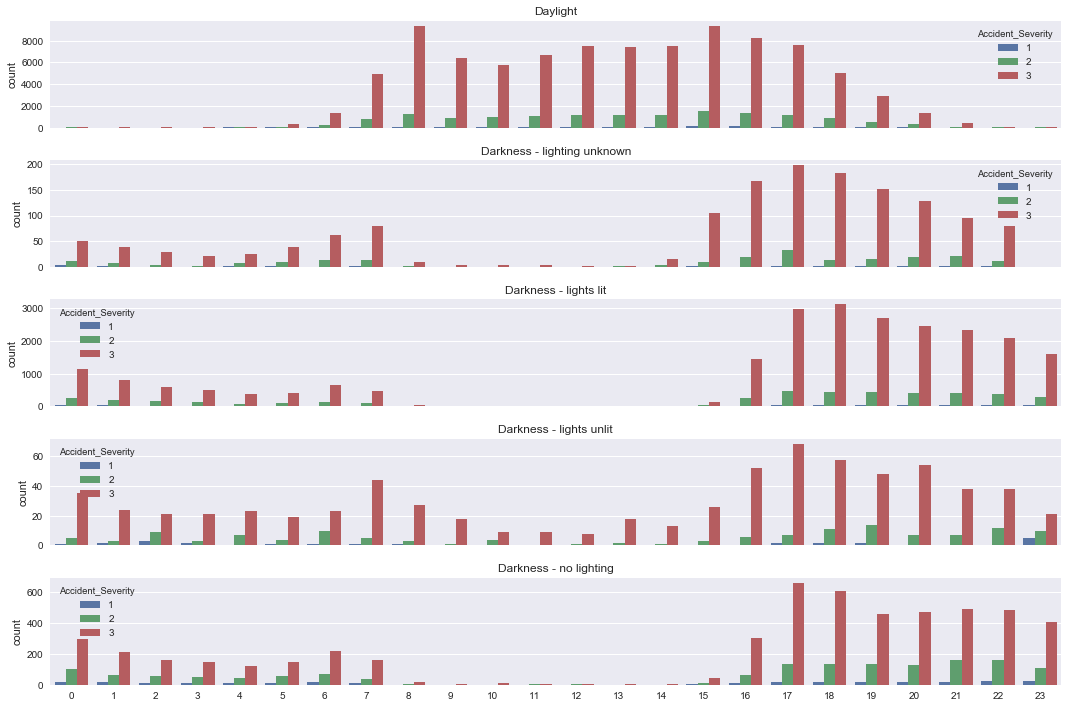

In [60]:
f, axes = plt.subplots(nrows=df['Light_Conditions'].nunique(), ncols=1, sharex = True)
for i,ax_val in zip(df['Light_Conditions'].unique(), range(df['Light_Conditions'].nunique())):
    i = str(i)
    data = df["Light_Conditions"] == i
    sns.countplot(x="Hour", data=df[data], hue = "Accident_Severity",  ax = axes[ax_val]);
    Title_Dictionary = {
    "1": "Daylight",
    "4": "Darkness - lights lit",
    "5": "Darkness - lights unlit",
    "6": "Darkness - no lighting",
    "7": "Darkness - lighting unknown"
    }

    axes[ax_val].set_title(Title_Dictionary[i])
    axes[ax_val].xaxis.label.set_visible(False)
plt.xlabel("Hour")
plt.tight_layout()

As we would expect, most Daylight accidents happens during the day, etc

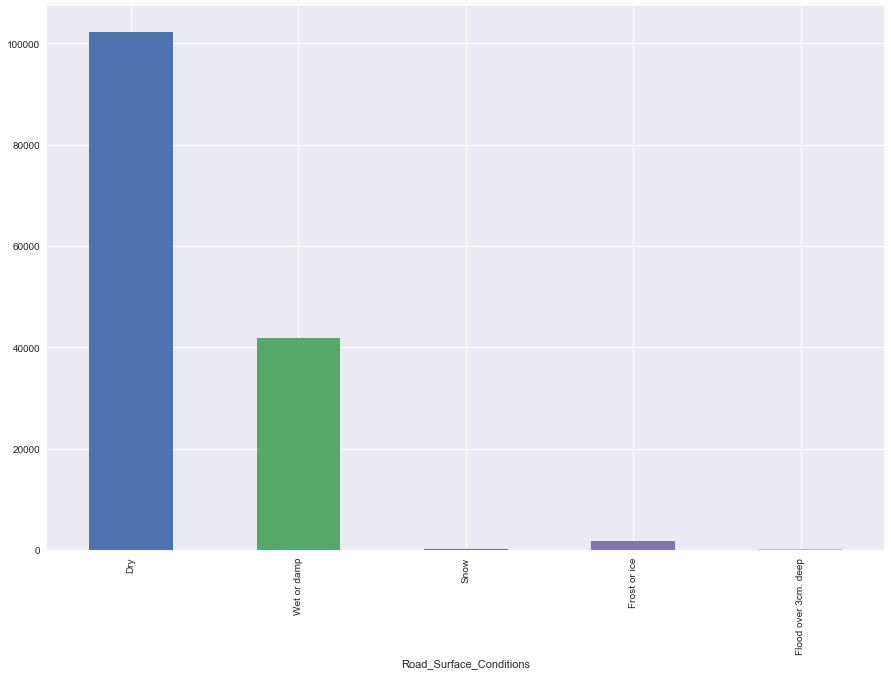

In [61]:
figure, ax = plt.subplots(1,1)
df.groupby(df.Road_Surface_Conditions).Accident_Severity.count().plot(kind = 'bar');
ax.set_xticklabels( ('Dry', 'Wet or damp','Snow', 'Frost or ice', 'Flood over 3cm. deep') );

In [62]:
grouped = df[["Road_Surface_Conditions", "Accident_Severity"]]\
.groupby(["Road_Surface_Conditions", "Accident_Severity"])["Accident_Severity"].count().sort_values(ascending=False)

In [63]:
grouped

Road_Surface_Conditions  Accident_Severity
1.0                      3                    86550
2.0                      3                    35576
1.0                      2                    14565
2.0                      2                     5841
4.0                      3                     1464
1.0                      1                     1112
2.0                      1                      517
5.0                      3                      212
4.0                      2                      203
3.0                      3                      185
5.0                      2                       48
4.0                      1                       25
3.0                      2                       19
5.0                      1                        2
3.0                      1                        2
Name: Accident_Severity, dtype: int64

In [64]:
grouped = df[["Road_Surface_Conditions", "Accident_Severity"]]\
.groupby(["Accident_Severity"])["Accident_Severity"].count()

In [65]:
grouped

Accident_Severity
1      1658
2     20676
3    123987
Name: Accident_Severity, dtype: int64

Surprisingly, most accidents happen when the road conditions are good. This could mean that people are less careful during good conditions.

The majority of fatal accidents happens in dry or damp road conditions.

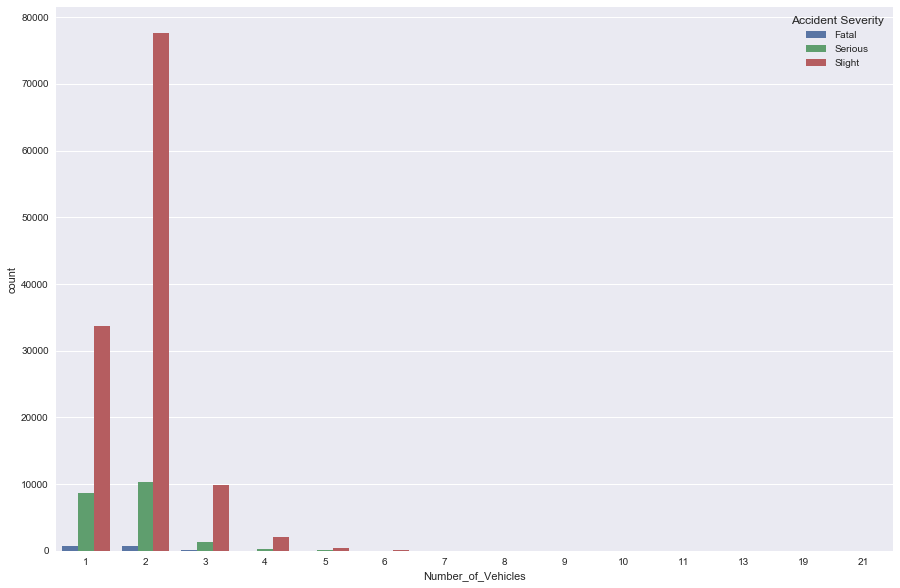

In [66]:
g = sns.countplot(x="Number_of_Vehicles", data=df, hue = "Accident_Severity");

g.legend(['Fatal', 'Serious', 'Slight'], title='Accident Severity', loc='upper right')


Most of the accidents are caused by up to 3 vehicles

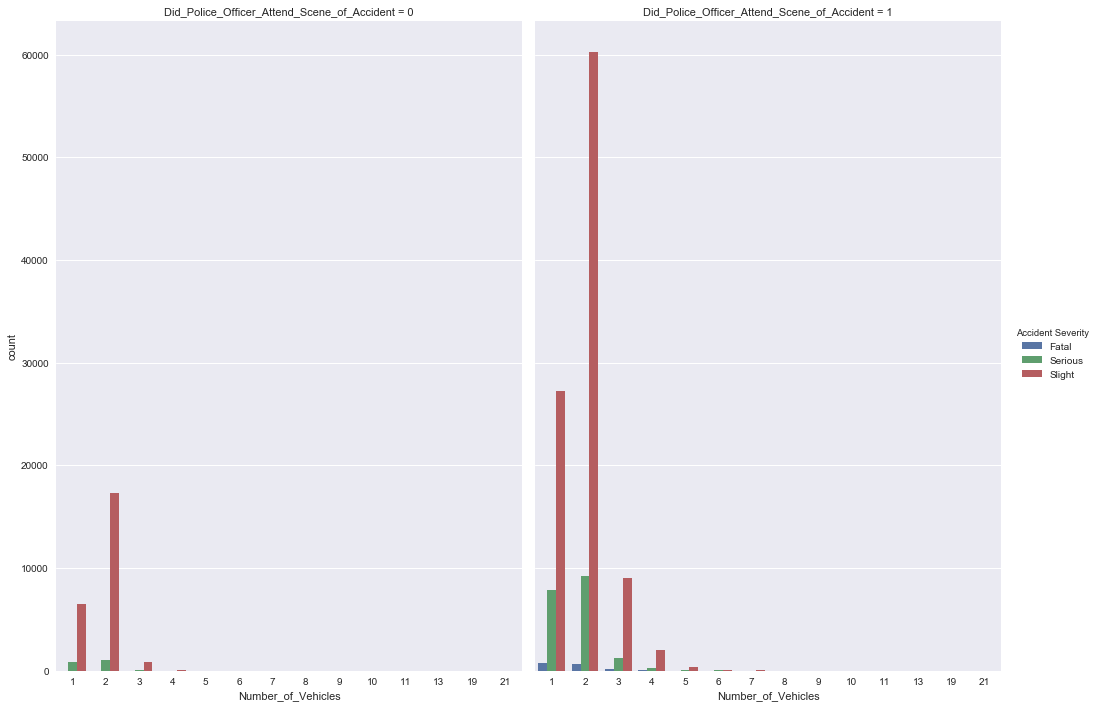

In [67]:
g=sns.factorplot(x="Number_of_Vehicles", hue="Accident_Severity", col="Did_Police_Officer_Attend_Scene_of_Accident",
                    data=df, kind="count",
                   size=10, aspect=.7);

legend = g._legend

legend.set_title("Accident Severity")
for t, l in zip(legend.texts,('Fatal', 'Serious', 'Slight')):
    t.set_text(l)

Accidents with more vehicles had more police presence at the scene

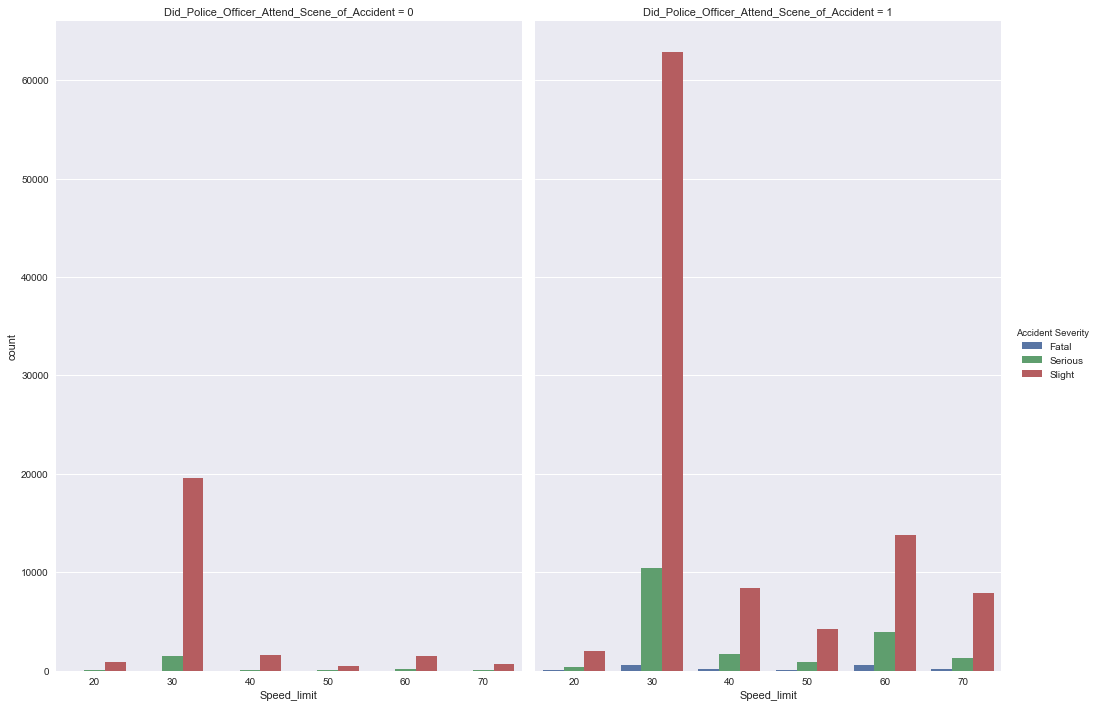

In [68]:
g=sns.factorplot(x="Speed_limit", hue="Accident_Severity", col="Did_Police_Officer_Attend_Scene_of_Accident",
                    data=df, kind="count",
                   size=10, aspect=.7);

legend = g._legend

legend.set_title("Accident Severity")
for t, l in zip(legend.texts,('Fatal', 'Serious', 'Slight')):
    t.set_text(l)

Most accidents occur where the speed limit is 30mph

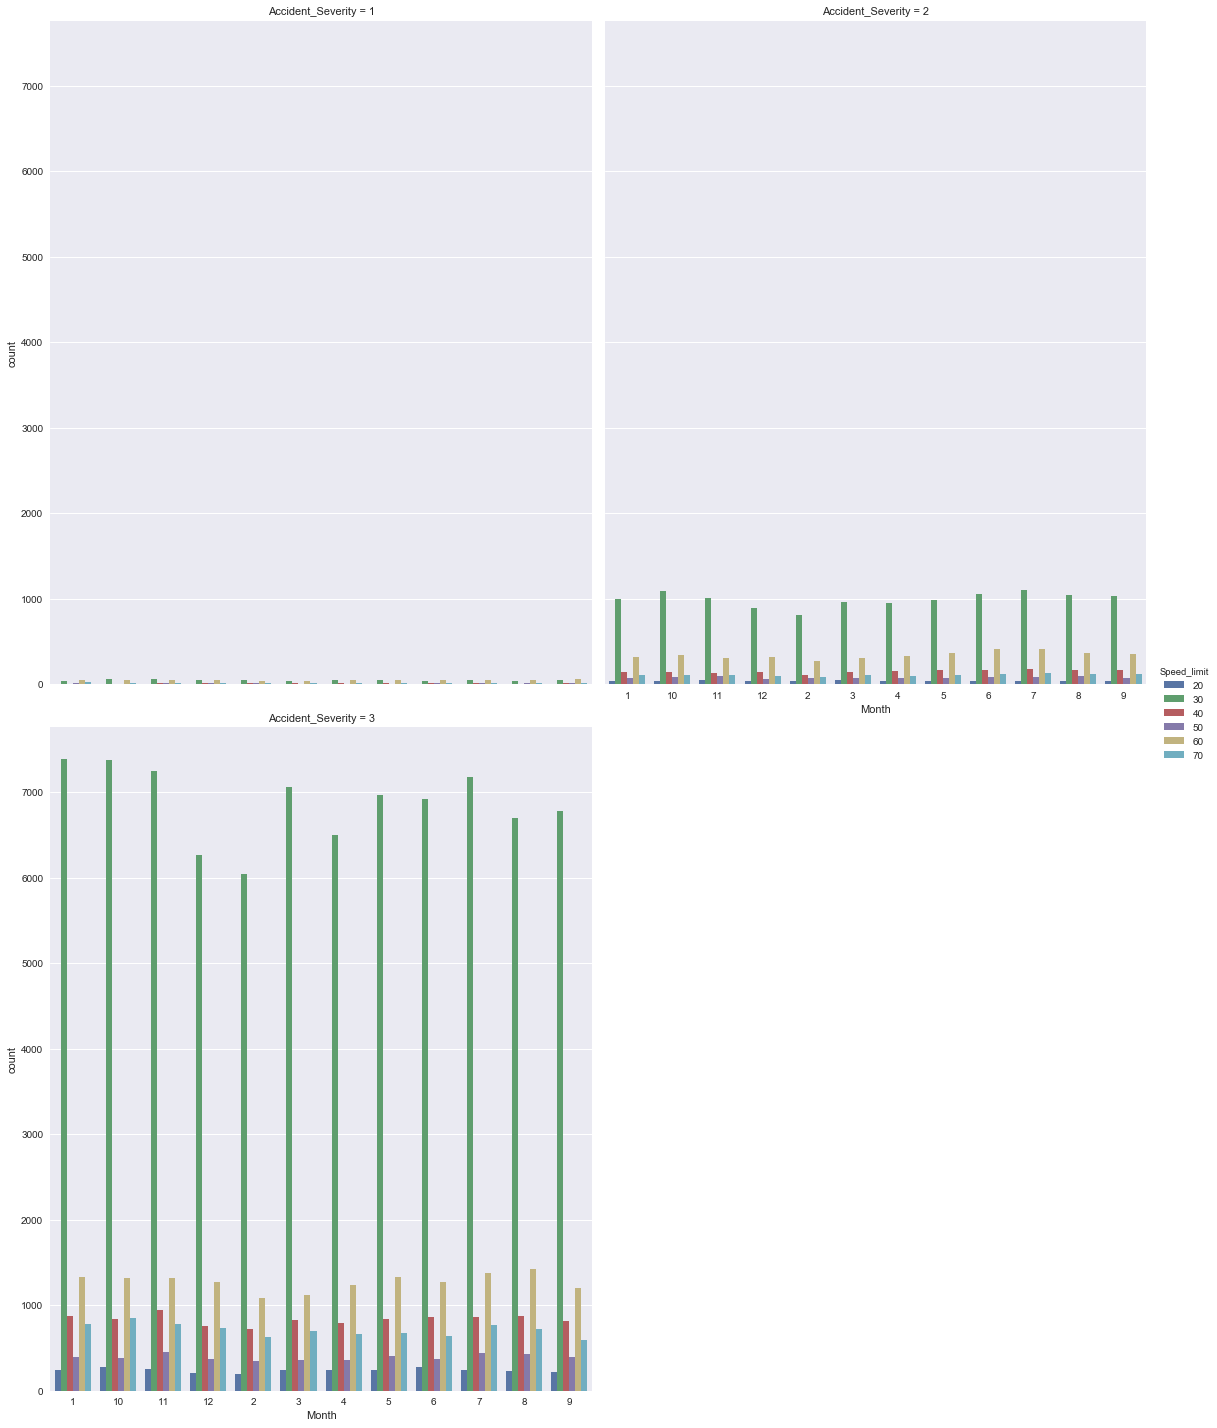

In [69]:
g=sns.factorplot(x="Month", hue="Speed_limit", col="Accident_Severity",
                    data=df, kind="count",
                   size=10, aspect=.8, col_wrap = 2);

legend = g._legend

Let's now deal with our cyclical feature: Hour and Month

We need to make sure the algorithm understand that for example 23h is close to 0h.

In [70]:
df["Hour"]=df["Hour"].astype(np.int64)
df["Month"]=df["Month"].astype(np.int64)
df['Hour_sin'] = np.sin(df.Hour*(2.*np.pi/24))
df['Hour_cos'] = np.cos(df.Hour*(2.*np.pi/24))
df['Month_sin'] = np.sin((df.Month-1)*(2.*np.pi/12))
df['Month_cos'] = np.cos((df.Month-1)*(2.*np.pi/12))

df["Day_of_Week"]=df["Day_of_Week"].astype(np.int64)
df['DayofWeek_sin'] = np.sin(df['Day_of_Week']*(2.*np.pi/7))
df['DayofWeek_cos'] = np.cos(df['Day_of_Week']*(2.*np.pi/7))

df.drop(['Hour', 'Month', 'Day_of_Week'], axis=1, inplace=True)

I will drop **Local_Authority_(District)** and **Accident_Index**

In [71]:
#df.drop(['Local_Authority_(District)', 'Accident_Index', '1st_Road_Number'], axis=1, inplace=True)
df.drop(['Accident_Index', '1st_Road_Number'], axis=1, inplace=True)

In [72]:
df.describe()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Number_of_Vehicles,Number_of_Casualties,Speed_limit,Hour_sin,Hour_cos,Month_sin,Month_cos,DayofWeek_sin,DayofWeek_cos
count,146321.000000,1.463210e+05,146321.000000,146321.000000,146321.000000,146321.000000,146321.000000,146321.000000,1.463210e+05,146321.000000,1.463210e+05,1.463210e+05,146321.000000
mean,447030.182223,2.903716e+05,-1.328700,52.500859,1.835177,1.329105,38.238667,-0.224025,-3.366612e-01,-0.014504,-1.590310e-02,-4.711681e-02,-0.039366
std,95158.135195,1.578202e+05,1.397354,1.421314,0.700211,0.857472,13.850198,0.705328,5.822293e-01,0.707255,7.066354e-01,7.072820e-01,0.704265
min,70951.000000,1.030400e+04,-7.450342,49.913077,1.000000,1.000000,20.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-9.749279e-01,-0.900969
25%,384365.000000,1.765900e+05,-2.235499,51.474928,1.000000,1.000000,30.000000,-0.866025,-8.660254e-01,-0.866025,-8.660254e-01,-7.818315e-01,-0.900969
50%,451307.000000,2.416200e+05,-1.238792,52.055123,2.000000,1.000000,30.000000,-0.500000,-5.000000e-01,0.000000,-1.836970e-16,-2.449294e-16,-0.222521
75%,526830.000000,3.911760e+05,-0.170581,53.414606,2.000000,1.000000,40.000000,0.500000,-1.836970e-16,0.500000,5.000000e-01,7.818315e-01,0.623490
max,655309.000000,1.190858e+06,1.758797,60.597984,21.000000,93.000000,70.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,9.749279e-01,1.000000


In [73]:
df.describe(include=['O'])

,Police_Force,Accident_Severity,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,Road_Type,Junction_Detail,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LA_Highway
count,146321,146321,146321,146321,146321,146321,146321,146321,146321,146321,146321,146321,146321,146321,146321,146321,146321
unique,51,3,380,207,6,6,9,3,6,5,9,5,8,6,2,2,207
top,1,3,300,E10000016,3,6,0,0,0,1,1,1.0,0.0,0.0,1,1,136
freq,25682,123987,2628,4618,67828,110186,56409,145537,118107,108070,118878,102227,143116,143909,96287,119607,4618


**Maps**

In [74]:
%%HTML
<iframe width = "100%" height = 500 src = "./accidents_fatal.html"></iframe>

In [75]:
%%HTML
<iframe width = "100%" height = 500 src = "./accidents_serious.html"></iframe>

In [76]:
%%HTML
<iframe width = "100%" height = 500 src = "./accidents_slight.html"></iframe>

Let's encode our columns

In [77]:
df.drop(["Date", "Longitude", "Latitude", "Location_Easting_OSGR", "Location_Northing_OSGR", "Local_Authority_(Highway)"], \
        axis = 1, inplace=True)

In [78]:
df['LA_Highway'].nunique()

207

In [79]:
df['Local_Authority_(District)'].nunique()

380

In [80]:
for col in df.columns:
    if df[col].dtype == "object" and col != "Did_Police_Officer_Attend_Scene_of_Accident":
       # encoding in dummy variable
        col_dummies = pd.get_dummies(df[col],prefix=col, drop_first = True)
        df = pd.concat([df,col_dummies],axis=1)
    
        # removing the col variable
        df.drop(col,axis=1,inplace=True)
    
        status(col)


Processing Police_Force : ok
Processing Accident_Severity : ok
Processing Local_Authority_(District) : ok
Processing 1st_Road_Class : ok
Processing Road_Type : ok
Processing Junction_Detail : ok
Processing Pedestrian_Crossing-Human_Control : ok
Processing Pedestrian_Crossing-Physical_Facilities : ok
Processing Light_Conditions : ok
Processing Weather_Conditions : ok
Processing Road_Surface_Conditions : ok
Processing Special_Conditions_at_Site : ok
Processing Carriageway_Hazards : ok
Processing Urban_or_Rural_Area : ok
Processing LA_Highway : ok


In [81]:
list(df)

['Number_of_Vehicles',
 'Number_of_Casualties',
 'Speed_limit',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'Hour_sin',
 'Hour_cos',
 'Month_sin',
 'Month_cos',
 'DayofWeek_sin',
 'DayofWeek_cos',
 'Police_Force_10',
 'Police_Force_11',
 'Police_Force_12',
 'Police_Force_13',
 'Police_Force_14',
 'Police_Force_16',
 'Police_Force_17',
 'Police_Force_20',
 'Police_Force_21',
 'Police_Force_22',
 'Police_Force_23',
 'Police_Force_3',
 'Police_Force_30',
 'Police_Force_31',
 'Police_Force_32',
 'Police_Force_33',
 'Police_Force_34',
 'Police_Force_35',
 'Police_Force_36',
 'Police_Force_37',
 'Police_Force_4',
 'Police_Force_40',
 'Police_Force_41',
 'Police_Force_42',
 'Police_Force_43',
 'Police_Force_44',
 'Police_Force_45',
 'Police_Force_46',
 'Police_Force_47',
 'Police_Force_48',
 'Police_Force_5',
 'Police_Force_50',
 'Police_Force_52',
 'Police_Force_53',
 'Police_Force_54',
 'Police_Force_55',
 'Police_Force_6',
 'Police_Force_60',
 'Police_Force_61',
 'Police_Force_62',
 '

# 3) Modelling

We saw that the classes are imbalanced. 
There are a few techniques used to solve this issue. For example, we can under-sample the majority class. However this approach can lead to loss of information. We could also over-sample, by duplicating the minority class - which could lead to overfitting.

Python has a library called *imbalanced-learn* that can help us

First I decided to experiment with Tomek Links. Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

The idea is to clarify the border between the minority and majority classes, making the minority region(s) more distinct.(under-samplying)

Then I decided to experiment with SMOTE (Synthetic Minority Oversampling TEchnique). This technique will synthesize elements from the monority class, based on the existing values.It will pick the minority class and compute k nearest neighbors for the points. These syntetic point will be added between the original points and the k nearest neightbors. Mor info [here](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) and [here](https://github.com/scikit-learn-contrib/imbalanced-learn#id38)

## 3.1) Train and Test split

The right way to prepare the train and test data sets is to keep the test as unseen new data.

Note that I am using the paameter *stratify*, in which training and test subsets will have the same proportions of class labels as the input dataset.

In [177]:
target = df["Did_Police_Officer_Attend_Scene_of_Accident"].values.astype(int)
new = df
new = new.drop(["Did_Police_Officer_Attend_Scene_of_Accident"], axis = 1)
x = new.values
X_train_orig, X_test_target, y_train_orig, y_test_target = train_test_split(x, target, test_size=0.2, stratify = target, random_state = 50618)

In [189]:
X_test_target.shape

(29265, 700)

Now it's time to oversample the training data:

In [178]:
x_train, x_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig,
                                                  test_size = .2,
                                                  random_state=50618)

In [190]:
x_train.shape

(93644, 700)

In [179]:
tl = TomekLinks(return_indices = True, ratio = 'majority', random_state = 50618)
X_train_tl, y_train_tl, id_tl = tl.fit_sample(x_train, y_train)

In [191]:
X_train_tl.shape

(88585, 700)

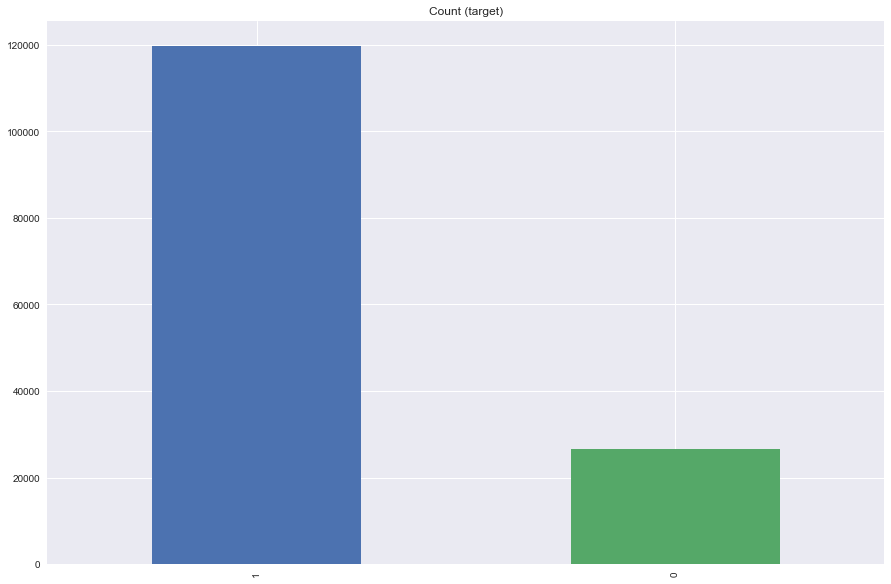

In [180]:
pd.value_counts(pd.Series(target)).plot(kind='bar', title='Count (target)');

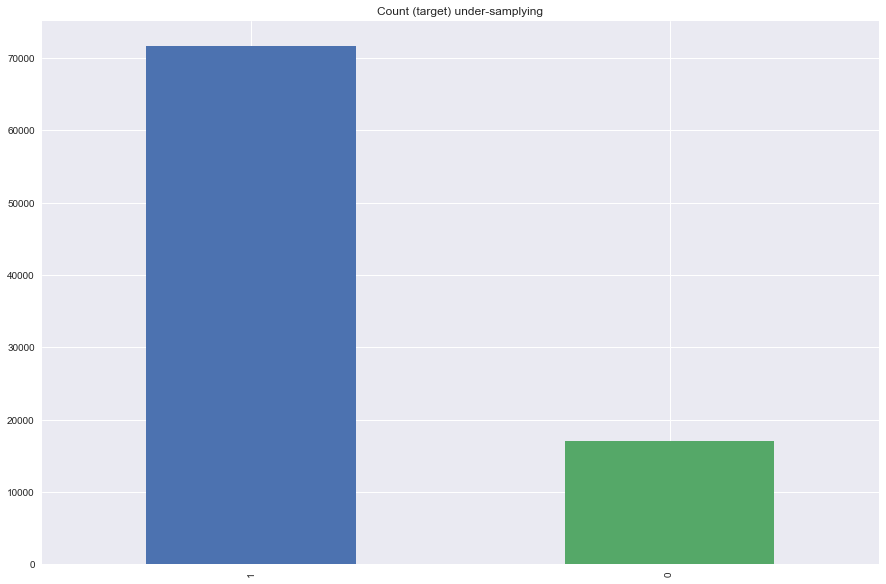

In [181]:
pd.value_counts(pd.Series(y_train_tl)).plot(kind='bar', title='Count (target) under-samplying');

------

In [182]:
smote = SMOTE(ratio='minority')
X_train_sm, y_train_sm = smote.fit_sample(x_train, y_train)

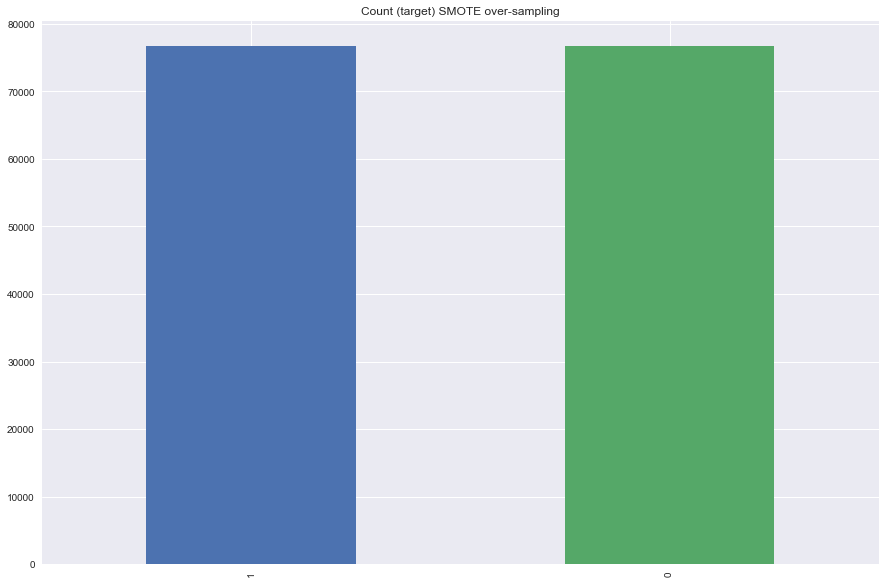

In [183]:
pd.value_counts(pd.Series(y_train_sm)).plot(kind='bar', title='Count (target) SMOTE over-sampling')

In [ ]:
# len(y_tl)

In [97]:
#X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.2, stratify = y_tl, random_state = 50618)

In [115]:
#X_tr, X_t, y_tr, y_t = train_test_split(X_sm, y_sm, test_size=0.2, stratify = y_sm, random_state = 50618)

In [ ]:
# idx_samples_removed = np.setdiff1d(np.arange(x.shape[0]),
#                                    id_tl)
# idx_class_0 = y_tl == 0
# plt.scatter(X_tl[idx_class_0, 0], X_tl[idx_class_0, 1],
#             alpha=1, label='Class #0')
# plt.scatter(X_tl[~idx_class_0, 0], X_tl[~idx_class_0, 1],
#             alpha=.8, label='Class #1')
# plt.scatter(x[idx_samples_removed, 0], x[idx_samples_removed, 1],
#             alpha=.8, label='Removed samples')

# # make nice plotting
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.get_xaxis().tick_bottom()
# ax.get_yaxis().tick_left()
# ax.spines['left'].set_position(('outward', 10))
# ax.spines['bottom'].set_position(('outward', 10))
# #ax.set_xlim([-5, 5])
# #ax.set_ylim([-5, 5])
# #plt.yticks(range(-5, 6))
# #plt.xticks(range(-5, 6))

# plt.title('Under-sampling removing Tomek links')
# plt.legend()

## 3.2) Feature Selection

### 3.2.1) Tomek links

In [184]:
clf_tl = RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state = 50618)
clf_tl = clf_tl.fit(X_train_tl, y_train_tl)

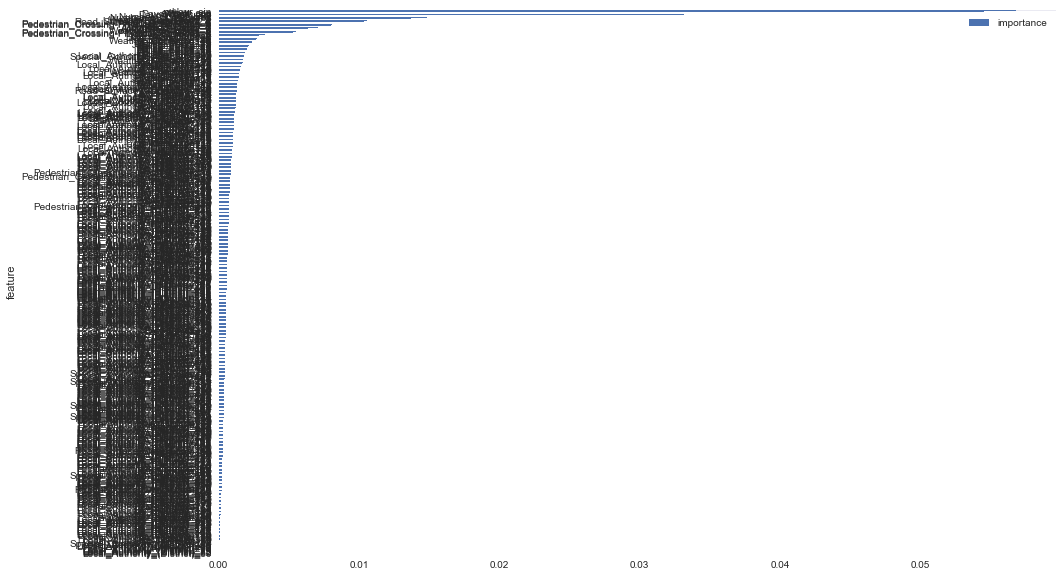

In [185]:
features = pd.DataFrame()
features['feature'] = new.columns
features['importance'] = clf_tl.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh')

In [186]:
model = SelectFromModel(clf_tl, prefit=True)
train_reduced_tl = model.transform(X_train_tl)
train_reduced_tl.shape

(88585, 86)

In [192]:
test_reduced_tl = model.transform(X_test_target)
test_reduced_tl.shape

(29265, 86)

### 3.2.2) SMOTE

In [193]:
clf_SMOTE = RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state = 50618)
clf_SMOTE = clf_SMOTE.fit(X_train_sm, y_train_sm)

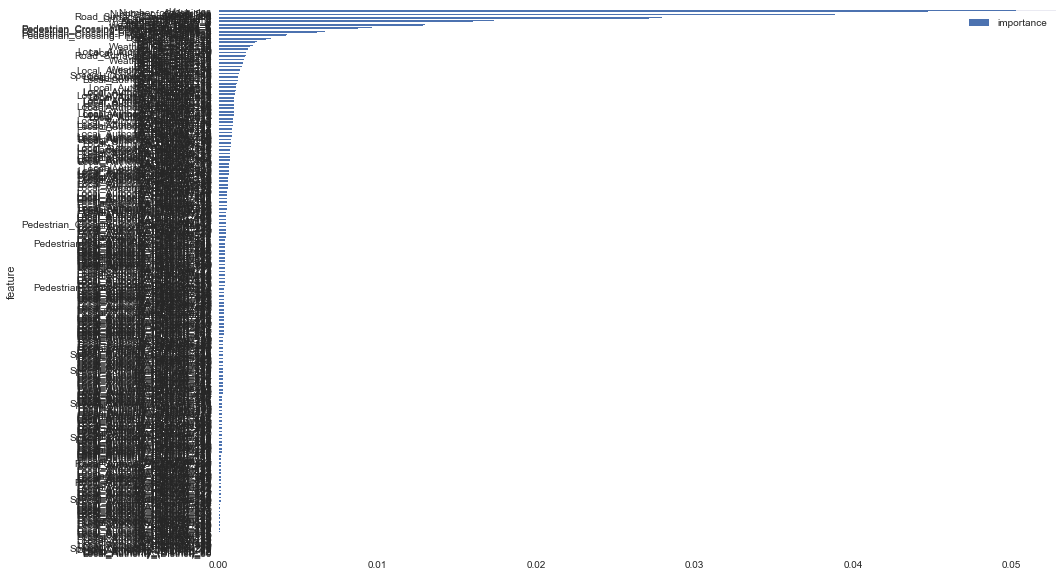

In [194]:
features = pd.DataFrame()
features['feature'] = new.columns
features['importance'] = clf_SMOTE.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh')

In [246]:
model_SMOTE = SelectFromModel(clf_SMOTE, prefit=True)
train_reduced_sm = model_SMOTE.transform(X_train_sm)
train_reduced_sm.shape

(153314, 74)

In [247]:
test_reduced_sm = model_SMOTE.transform(X_test_target)
test_reduced_sm.shape

(29265, 74)

In [249]:
X_val = model_SMOTE.transform(x_val)
X_val.shape

(23412, 74)

## 3.3) Pipeline

### 3.3.1) Tomek links

In [ ]:
# seed = 50618
# pipelines = []
# n_estimators = 200


# pipelines.append(
#                 ("SVC", 
#                  Pipeline([
#                      ("Scaler", StandardScaler()), 
#                      ("SVC", SVC(random_state=seed))
#                       ]))
#                 )

# pipelines.append(
#                 ("KNN", 
#                  Pipeline([
#                      ("Scaler", StandardScaler()), 
#                      ("KNN", KNeighborsClassifier())
#                       ]))
#                 )

# pipelines.append(
#                 ("RF",
#                  Pipeline([
#                      ("Scaler", StandardScaler()),
#                      ("RF", RandomForestClassifier(random_state=seed, n_estimators=n_estimators))
#                  ])
#                 )
#                 )

# pipelines.append(
#                 ("XGB",
#                  Pipeline([
#                      ("Scaler", StandardScaler()),
#                      ("XGB", GradientBoostingClassifier(random_state=seed))
#                  ])
#                 )
#                 )

# scoring = 'accuracy'
# n_folds = 10
# results, names  = [], [] 

# for name, model  in pipelines:
#     kfold = KFold(n_splits=n_folds, shuffle=False, random_state=seed)
#     cv_results = cross_val_score(model, train_reduced, y_train, cv= kfold,
#                                  scoring=scoring, n_jobs=-1)    
#     names.append(name)
#     results.append(cv_results)    
#     msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
#     print(msg)
    
# results = pd.DataFrame(np.array(results).T, columns = names)  
# plt.figure()
# sns.boxplot(data=results)

Unfortunately, after 4h waiting, the above code block did not finish running. Let's do something simpler so we can choose the model

In [198]:
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [knn, rf, gboost]

In [199]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [201]:
for model in models:
    print ('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced_tl, y=y_train_tl, scoring='accuracy')
    print ('CV score = {0}'.format(score))
    print ('****')

Cross-validation of : <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
CV score = 0.7852345435425873
****
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.7845685821898887
****
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.812891595526651
****


In [202]:
for model in models:
    print ('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced_tl, y=y_train_tl, scoring='f1')
    print ('CV score = {0}'.format(score))
    print ('****')

Cross-validation of : <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
CV score = 0.8753539297966265
****
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.8727065144928012
****
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.8957290288694082
****


In [ ]:
# for model in models:
#     print ('Cross-validation of : {0}'.format(model.__class__))
#     scoring = {'acc': 'accuracy',
#            'prec_macro': 'precision_macro',
#            'rec_micro': 'recall_macro'}
#     score = compute_score(clf=model, X=train_reduced, y=y_train, scoring=scoring)
#     print ('CV score = {0}'.format(score))
#     print ('****')

In [207]:
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

for model in models:
    #clf = model
    scoring = {'acc': 'accuracy',
               'prec_macro': 'precision_macro',
               'rec_micro': 'recall_macro'}
    scores = cross_validate(model, X=train_reduced_tl, y=y_train_tl, scoring=scoring,
                             cv=5, return_train_score=True)
    print(scores.keys())
    print(scores['test_acc'])  

dict_keys(['fit_time', 'score_time', 'test_acc', 'train_acc', 'test_prec_macro', 'train_prec_macro', 'test_rec_micro', 'train_rec_micro'])
[0.78423073 0.78360989 0.78845177 0.78409347 0.78578686]
dict_keys(['fit_time', 'score_time', 'test_acc', 'train_acc', 'test_prec_macro', 'train_prec_macro', 'test_rec_micro', 'train_rec_micro'])
[0.78293261 0.78321481 0.78557318 0.78443215 0.78381124]
dict_keys(['fit_time', 'score_time', 'test_acc', 'train_acc', 'test_prec_macro', 'train_prec_macro', 'test_rec_micro', 'train_rec_micro'])
[0.81205554 0.81295857 0.81244003 0.81389704 0.8131068 ]


The best performances are achieved by GradientBoostingClassifier

### 3.3.2) SMOTE

In [208]:
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [knn, rf, gboost]

In [211]:
y_train_sm.shape

(153314,)

In [215]:
for model in models:
    print ('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced_sm, y=y_train_sm, scoring='accuracy')
    print ('CV score = {0}'.format(score))
    print ('****')

Cross-validation of : <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
CV score = 0.7781940177616045
****
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.8546022207442506
****
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.8443427507988218
****


In [216]:
for model in models:
    print ('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced_sm, y=y_train_sm, scoring='f1')
    print ('CV score = {0}'.format(score))
    print ('****')

Cross-validation of : <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
CV score = 0.7328106328599139
****
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.8784797223702336
****
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.8757754416175952
****


In [217]:
for model in models:
    scoring = {'acc': 'accuracy',
               'prec_macro': 'precision_macro',
               'rec_micro': 'recall_macro'}
    scores = cross_validate(model, X=train_reduced_sm, y=y_train_sm, scoring=scoring,
                             cv=5, return_train_score=True)
    print(scores.keys())
    print(scores['test_acc'])  

dict_keys(['fit_time', 'score_time', 'test_acc', 'train_acc', 'test_prec_macro', 'train_prec_macro', 'test_rec_micro', 'train_rec_micro'])
[0.75887034 0.77869815 0.78481508 0.78383667 0.78474985]
dict_keys(['fit_time', 'score_time', 'test_acc', 'train_acc', 'test_prec_macro', 'train_prec_macro', 'test_rec_micro', 'train_rec_micro'])
[0.56173363 0.90549178 0.93522927 0.93653382 0.93516405]
dict_keys(['fit_time', 'score_time', 'test_acc', 'train_acc', 'test_prec_macro', 'train_prec_macro', 'test_rec_micro', 'train_rec_micro'])
[0.50632664 0.90011088 0.93637075 0.93588155 0.94305655]


F1 score is the weighted average of Precision and Recall. F1 score takes both false positives and false negatives into account. F1 score is usually more useful than accuracy for an uneven class distribution. 

## 3.4) Model tuning

### 3.4.1) Tomek links

In [219]:
seed = 50618

# turn run_gs to True if you want to run the gridsearch again.
run_gs = True
pipeline = make_pipeline(preprocessing.StandardScaler(),GradientBoostingClassifier(random_state = seed))

print("done: pipeline")

if run_gs:
    
    # Set the grid parameters
    gb_param_grid =  {
        'n_estimators': [100, 200,300,400],
        'max_features':[0.05 , 0.1], 
        'max_depth': [3, 5, 7], # Max depth of the trees
        'min_samples_split': [0.005, 0.01], 
 
        }
    
    XGB = GradientBoostingClassifier()
    print("Stratified K Fold")
    cross_validation = StratifiedKFold(n_splits=5)
    
    print ("done: classifier")
    
    grid_search = GridSearchCV(XGB,param_grid = gb_param_grid, cv=cross_validation, scoring="accuracy")
    print('Will fit now')
    grid_search.fit(train_reduced_tl, y_train_tl)
    
    model = grid_search
    
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    print('Best estimator: {}'.format(grid_search.best_estimator_))

else: 
    parameters = {'n_estimators': 200, 'max_depth': 5,
                  'min_samples_split': 0.005, 'max_features': 0.1}
    
    model = GradientBoostingClassifier(**parameters)
    model.fit(train_reduced_tl, y_train_tl)

done: pipeline
Stratified K Fold
done: classifier
Will fit now
Best score: 0.8143365129536603
Best parameters: {'max_depth': 5, 'max_features': 0.1, 'min_samples_split': 0.01, 'n_estimators': 300}
Best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=0.01,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [220]:
# save the model to disk
filename = 'XGBoost_Tomek_links_python3p6.dat'
pickle.dump(model, open(filename, 'wb'))

### 3.4.2) SMOTE

In [221]:
seed = 50618

# turn run_gs to True if you want to run the gridsearch again.
run_gs = True
pipeline = make_pipeline(preprocessing.StandardScaler(),GradientBoostingClassifier(random_state = seed))

print("done: pipeline")

if run_gs:
    
    # Set the grid parameters
    gb_param_grid =  {
        'n_estimators': [100, 200,300,400],
        'max_features':[0.05 , 0.1], 
        'max_depth': [3, 5, 7], # Max depth of the trees
        'min_samples_split': [0.005, 0.01], 
 
        }
    
    XGB = GradientBoostingClassifier()
    print("Stratified K Fold")
    cross_validation = StratifiedKFold(n_splits=5)
    
    print ("done: classifier")
    
    grid_search = GridSearchCV(XGB,param_grid = gb_param_grid, cv=cross_validation, scoring="accuracy")
    print('Will fit now')
    grid_search.fit(train_reduced_sm, y_train_sm)
    
    model_SMOTE = grid_search
    
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    print('Best estimator: {}'.format(grid_search.best_estimator_))

else: 
    parameters = {'n_estimators': 400, 'max_depth': 7,
                  'min_samples_split': 0.01, 'max_features': 0.1}
    
    model_SMOTE = GradientBoostingClassifier(**parameters)
    model_SMOTE.fit(train_reduced_sm, y_train_sm)

done: pipeline
Stratified K Fold
done: classifier
Will fit now
Best score: 0.8775454296411287
Best parameters: {'max_depth': 7, 'max_features': 0.1, 'min_samples_split': 0.01, 'n_estimators': 400}
Best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=0.01,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [222]:
# save the model to disk
filename = 'XGBoost_SMOTE_python3p6.dat'
pickle.dump(model_SMOTE, open(filename, 'wb'))

## 3.5) Model Prediction

### 3.5.1) Tomek links

In [224]:
# make predictions for test data
#y_pred = model.predict(test_reduced)
filename = 'XGBoost_Tomek_links_python3p6.dat'
model_Tomek_links = pickle.load(open(filename, 'rb'))
y_pred_Tomek = model_Tomek_links.predict(test_reduced_tl)

In [228]:
# evaluate predictions

# accuracy score
accuracy = accuracy_score(y_test_target, y_pred_Tomek)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Classification report:
print (classification_report(y_test_target, y_pred_Tomek))
cm = confusion_matrix(y_test_target, y_pred_Tomek)
print ("Confusion Matrix \n", cm)

Accuracy: 82.27%
             precision    recall  f1-score   support

          0       0.60      0.09      0.15      5343
          1       0.83      0.99      0.90     23922

avg / total       0.79      0.82      0.76     29265

Confusion Matrix 
 [[  473  4870]
 [  320 23602]]


473 TP and 23602 TN

Precision is the ability of the classifier to not label a positive sample as negative.

60% ratio of correctly predicted 0 to the total of 0 and 83% ratio of correctly predicted 1.

We can see that the estimator is good at recognizing the class 1 (precision, recall and f1-score are close to 100%), howerver it's fails for class 0. It could be due to the fact that the classes are not balanced.

In [229]:
# predict class  probabilities
prob_y_1 = model_Tomek_links.predict_proba(test_reduced_tl)[:,1] # class1
print(prob_y_1 * 100) 

prob_y_0 = model_Tomek_links.predict_proba(test_reduced_tl)[:,0] # class0
print(prob_y_0 * 100) 

[84.25902625 74.1957781  90.32372444 ... 75.49979742 72.45323023
 62.37576538]
[15.74097375 25.8042219   9.67627556 ... 24.50020258 27.54676977
 37.62423462]


In [230]:
y_test_int = y_test_target.astype(int)
roc_auc_score(y_test_int, prob_y_1) * 100

74.14644063666708

Around 74% chance of the model built to "rank" class 1 as 1

In [231]:
roc_auc_score(y_test_int, prob_y_0) * 100

25.853559363332913

Around 26% chance the model will rank class 0 as 0

### 3.5.2) SMOTE

In [263]:
#.value_counts()

pd.value_counts(pd.Series(y_test_target))

1    23922
0     5343
dtype: int64

In [252]:
# make predictions for test data
filename = 'XGBoost_SMOTE_python3p6.dat'
model_SMOTE = pickle.load(open(filename, 'rb'))
y_pred_SMOTE = model_SMOTE.predict(test_reduced_sm)

In [259]:
# make predictions for test data
filename = 'XGBoost_SMOTE_python3p6.dat'
model_SMOTE = pickle.load(open(filename, 'rb'))
y_pred_SMOTE_val = model_SMOTE.predict(X_val)

In [267]:
# evaluate predictions

# accuracy score
accuracy = accuracy_score(y_test_target, y_pred_SMOTE)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Classification report:
print (classification_report(y_test_target, y_pred_SMOTE))
cm = confusion_matrix(y_test_target, y_pred_SMOTE)
print ("Confusion Matrix \n", cm)

Accuracy: 82.09%
             precision    recall  f1-score   support

          0       0.56      0.09      0.15      5343
          1       0.83      0.98      0.90     23922

avg / total       0.78      0.82      0.76     29265

Confusion Matrix 
 [[  479  4864]
 [  377 23545]]


In [268]:
# evaluate predictions

# accuracy score
accuracy = accuracy_score(y_val, y_pred_SMOTE_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Classification report:
print (classification_report(y_val, y_pred_SMOTE_val))
cm = confusion_matrix(y_val, y_pred_SMOTE_val)
print ("Confusion Matrix \n", cm)

Accuracy: 81.65%
             precision    recall  f1-score   support

          0       0.56      0.09      0.15      4384
          1       0.82      0.98      0.90     19028

avg / total       0.78      0.82      0.76     23412

Confusion Matrix 
 [[  391  3993]
 [  302 18726]]


In [256]:
from sklearn.metrics import recall_score
print ('Validation Results')
print (model_SMOTE.score(X_val, y_val))
print (recall_score(y_val, model_SMOTE.predict(X_val)))
print ('\nTest Results')
print (model_SMOTE.score(test_reduced_sm, y_test_target))
print (recall_score(y_test_target, model_SMOTE.predict(test_reduced_sm)))

Validation Results
0.8165470698786946
0.9841286525120875

Test Results
0.820912352639672
0.9842404481230667


Recall is the ability of the classifier to find all the positive (1) samples. 

The validation results closely match the test (unseen) data. This is what I would like to want to see for a production model.

The accuracy for both sets are over 80% and the recall is about 98% for 1 and around 1% for 0.

# 4) Ideas

1) Use the distance of the nearest police station

2) Encode Local_Authority_(District) instead of dropping it

3) Research about the use of Easting and Northing in machine learning models

4) Get data about population population size and check if that would be a factor for the police to attend the scene or not

5) More feature engineering: how could we use easting and northing information, etc

6) The classes are unbalanced. Could attempt up-sampling the minority class or downsampling the majority class. For performance metric we could use *Area Under ROC Curve*

7) Spend more time doing data exploration and visualization
